# Deep Lab Architecture

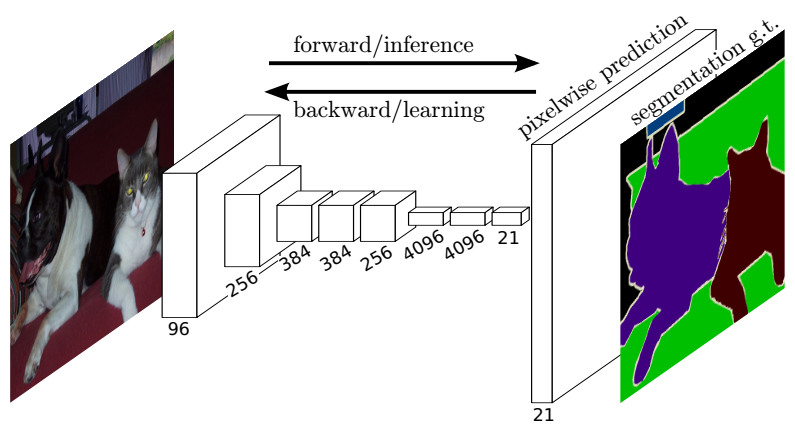

# Import Libraries

In [1]:
import os
import tarfile
from six.moves import urllib
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

In [2]:
# Custom Progress Bar
import progressbar

class MyProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        
        if downloaded < total_size:
            self.pbar.update(downloaded)
        
        else:
            self.pbar.finish()

# Downloading the pretrained model

In [3]:
def download_model(model_name = 'deeplabv3_pascal_train_aug_2018_01_04.tar.gz'):
  '''
  Download Deeplab V3 model to current directory.
  '''
  curr_dir = os.getcwd()
  download_prefix = 'http://download.tensorflow.org/models/'
  download_path = os.path.join(curr_dir,model_name )
  print('Downloading model.')
  urllib.request.urlretrieve(download_prefix + model_name, download_path, MyProgressBar())
  print('Download completed.')


# DeepLab V3

In [4]:
class DupModel(object):

  def __init__(self, 
               download_model_fp, 
               frozen_gn = 'frozen_inference_graph',
               input_tensor_name = 'ImageTensor:0',
               output_tensor_name = 'SemanticPredictions:0',
               input_size = 513):
    
    # Create an instance of tensorflow Graph 
    self.graph = tf.Graph()
    self.input_tensor_name = input_tensor_name
    self.output_tensor_name = output_tensor_name
    self.input_size = input_size

    gd = None
    # Load the graph model from the tar file that was downloaded

    tarfile_read = tarfile.open(download_model_fp)
    # We will read in the file content with extracting it. 
    # It does not make sense to extract the full file (waste of space), i.e.,
    # if we are using only a single file from within the tar file.


    for tar_info in tarfile_read.getmembers():     
      # Here we are checking to find the frozen inference graph file.
      # This protobuf file contains the graph definiton and the 
      # trained weights.
      if frozen_gn in os.path.basename(tar_info.name):
        # Extract the file
        file_handle = tarfile_read.extractfile(tar_info)
        # Read in the graph from string file
        gd = tf.compat.v1.GraphDef.FromString(file_handle.read())
        break

    tarfile_read.close()

    if gd is None:
      raise RuntimeError('The tar file is missing. Check frozen_gn param again!')

    # Import the graph from the file
    with self.graph.as_default():
      tf.graph_util.import_graph_def(gd, name='dupmodel')

    # Load the graph in tensorflow session
    self.sess = tf.compat.v1.Session(graph=self.graph)


  def run(self, input_image):
    '''Run a single image prediction/inference.

    '''
    # Read in the size of the image.
    w, h = input_image.size
    # Calculate the resize ratio. Example, target_size = max(w,h) * ratio
    # Therefore, ratio = target_size /  max(w,h)
    # This will help us to scale down the image, without messing up
    # the aspect ratio.
    resize_ratio = float(self.input_size) / max(w, h)
    target_size = (int(resize_ratio * w), int(resize_ratio * h))
    # Convert the input image (PIL image BGR) to RGB and resize the image.
    # Use antialiasing to make smoother images.
    resized_image = np.asarray(input_image.convert('RGB').resize(target_size, Image.ANTIALIAS))
    # Run the model, that outputs the segmentation mapping.
    segplot = self.sess.run('dupmodel/'+
                             self.output_tensor_name,
                             feed_dict=
                             {'dupmodel/'+
                              self.input_tensor_name: 
                              [resized_image]
                              }
                             )
    # Return the image, and segmentation map.
    return resized_image, segplot[0]

    
  @classmethod
  def inference_process(cls, path, model_name = 'deeplabv3_pascal_train_aug_2018_01_04.tar.gz'):
    """Inferences of the model and visualizes result."""
    download_path = os.path.join(os.getcwd(), model_name)
    if not os.path.isfile(download_path): 
      download_model()  
    try:
      original_im = Image.open(path)
    except IOError:
      print('Cannot open image. Please check image path: ' ,path)
      return

    print('Model processing image %s...' % path)
    model = cls(download_path)
    resized_im, seg_map = model.run(original_im)
    return resized_im, seg_map


# Inference on the image

In [5]:
path = '/content/000000003004.jpg'
res = DupModel.inference_process(path)

100% (460058541 of 460058541) |##########| Elapsed Time: 0:00:04 Time:  0:00:04


Download completed.
Model processing image /content/000000003004.jpg...


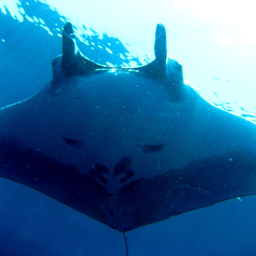

In [6]:
Image.open(path).resize((256,256))

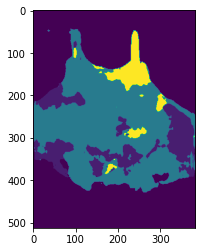

In [7]:
import matplotlib.pyplot as plt
plt.imshow(res[1])

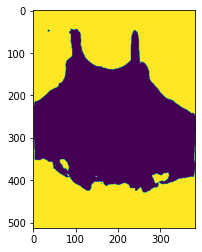

In [8]:
mask = (res[1] <= 0).astype(int)
plt.imshow(mask)

In [9]:
mask3d = np.moveaxis(np.tile(mask,(3,1,1)), 0, -1)

In [10]:
mask3d.shape

(513, 383, 3)

In [11]:
original_image = np.array(res[0])

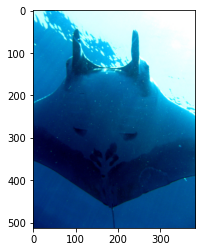

In [12]:
plt.imshow(original_image)

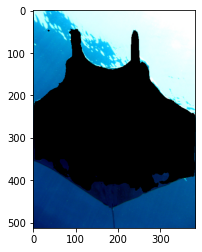

In [13]:
plt.imshow(original_image * mask3d)

In [15]:
mask_gen = Image.fromarray(np.where(mask3d == 0, 255, 0).astype(np.uint8))

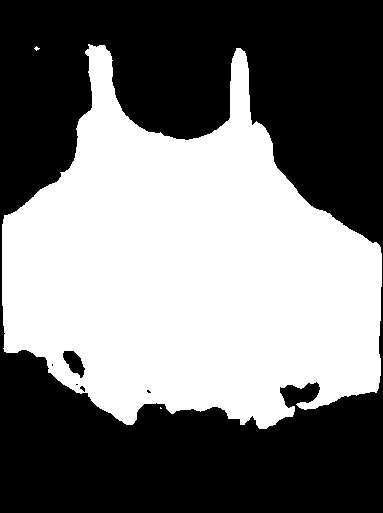

In [16]:
mask_gen

In [19]:
mask_true = np.asarray(Image.open('mask_true.png'))

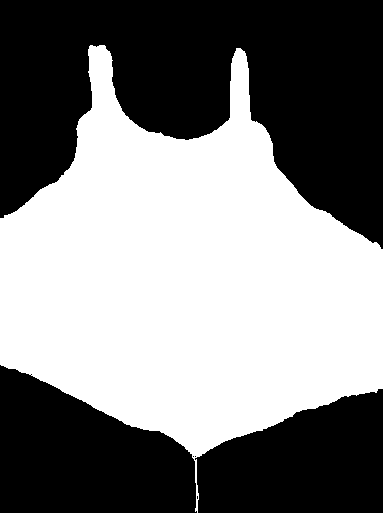

In [36]:
Image.fromarray()

### IOU Calculation

In [39]:
intersection = np.logical_and(np.asarray(mask_gen)[:,:,0], mask_true[:, :, 0])
union = np.logical_or(np.asarray(mask_gen)[:,:,0], mask_true[:, :, 0])
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is %s' % iou_score)

IoU is 0.9311406663087629


In [21]:
mask_true.shape

(513, 383, 4)